# Brain Tumor Classification (CMPS 261 - Spring 2025)

This notebook trains a deep learning model to classify brain MRI scans as either containing a tumor or not. 
The dataset contains `.jpg` images and `.txt` labels. This project focuses on the classification aspect.

## Workflow:
1. Load and clean dataset
2. Build TensorFlow data pipeline
3. Build and train CNN model
4. Evaluate and save model


### Understanding Data

In [35]:
import os

# Defining paths to image and label folders respectively:
image_dir = './data/images/'
label_dir = './data/labels/'

# Count # of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
num_images = len(image_files)

print(f"Total number of images: {num_images}")

# Count # of text files
image_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
num_labels = len(image_files)

print(f"Total number of labels: {num_labels}")

# Check how many images are missing labels
print(f'There are {num_images - num_labels} images missing a label!')

Total number of images: 893
Total number of labels: 878
There are 15 images missing a label!


### Before I proceed with anything I think it's best for me to test how exactly we're supposed to use the data.

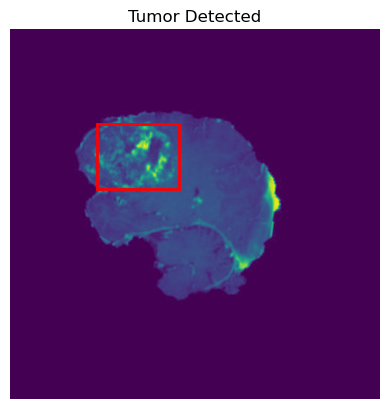

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === Step 1: Load the image ===
image_path = image_dir + '00054_145.jpg'
label_path = label_dir + '00054_145.txt'

image = Image.open(image_path)
img_width, img_height = image.size

# === Step 2: Read the label ===
with open(label_path, 'r') as f:
    line = f.readline().strip()
    parts = line.split()
    label = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

# === Step 3: Convert normalized values to pixels ===
x_center_pixel = x_center * img_width
y_center_pixel = y_center * img_height
box_width_pixel = width * img_width
box_height_pixel = height * img_height

# Convert from center to top-left corner
x_min = x_center_pixel - (box_width_pixel / 2)
y_min = y_center_pixel - (box_height_pixel / 2)

# === Step 4: Plot image and box ===
fig, ax = plt.subplots(1)
ax.imshow(image)

# Only draw the box if there's a tumor
if label == 1:
    rect = patches.Rectangle(
        (x_min, y_min),
        box_width_pixel,
        box_height_pixel,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.title("Tumor Detected")
else:
    plt.title("No Tumor")

plt.axis('off')
plt.show()

### Okay now we can begin with processing the data. First let's find out how many usable pairs we have:

In [37]:
# Helper: get filenames without extension
image_files = set(f[:-4] for f in os.listdir(image_dir) if f.endswith('.jpg'))
label_files = set(f[:-4] for f in os.listdir(label_dir) if f.endswith('.txt'))

# Intersection → only matched pairs
valid_ids = sorted(image_files & label_files)
print(f"Total valid image-label pairs: {len(valid_ids)}")

# Final dataset list
dataset = []

for img_id in valid_ids:
    label_path = os.path.join(label_dir, img_id + '.txt')
    image_path = os.path.join(image_dir, img_id + '.jpg')
    
    with open(label_path, 'r') as f:
        parts = f.readline().strip().split()
        label = int(parts[0])

        if label == 0:
            # No tumor: ignore bbox
            dataset.append((image_path, label, None))
        else:
            # Tumor: include bbox
            bbox = list(map(float, parts[1:]))
            dataset.append((image_path, label, bbox))

print(f"Prepared dataset with {len(dataset)} usable samples")

Total valid image-label pairs: 878
Prepared dataset with 878 usable samples


### Now that we've gathered our pairs we need to create a pipeline that handles:
1. The preprocessing of the images
2. and can be used to feed them directly to the model

In [38]:
import tensorflow as tf

# === Settings ===
IMG_SIZE = (224, 224)       # Target image dimensions (height, width)
BATCH_SIZE = 32             # Number of samples per training batch

# === Step 1: Creating TensorFlow Dataset Pipeline ===
def data_generator():
    """Generator that yields (image_path, label, bbox) tuples from the dataset."""
    for image_path, label, bbox in dataset:
        # For negative samples (label == 0), supply a dummy bbox
        if bbox is None:
            bbox = [0.0, 0.0, 0.0, 0.0]
        yield image_path.encode(), label, bbox  # Encode path as bytes for TensorFlow

# Define the output signature for the base dataset
output_signature = (
    tf.TensorSpec(shape=(), dtype=tf.string),   # image_path (scalar string)
    tf.TensorSpec(shape=(), dtype=tf.int32),    # label (scalar integer)
    tf.TensorSpec(shape=(4,), dtype=tf.float32) # bbox (4 float values: x_center, y_center, width, height)
)

# Create the base dataset from the generator
base_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=output_signature
)

# === Step 2: Image Preprocessing Function ===
# Now we define a helper method for image preprocessing.
def load_and_preprocess(image_path, label, bbox):
    """Load, decode, and preprocess an image and its label.
    Args:
        image_path: Path to the image file (tf.string).
        label: Class label (0 = no tumor, 1 = tumor).
        bbox: Bounding box coordinates (ignored in this function).
    Returns:
        Tuple of (normalized image tensor, label).
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB format
    image = tf.image.resize(image, IMG_SIZE)         # Resize to target dimensions
    image = tf.cast(image, tf.float32) / 255.0       # Normalize pixel values to [0, 1]
    return image, label # I'm igoring bbox for now!

# === Step 3: Optimize the Dataset Pipeline ===
final_dataset = (
    base_dataset
    .map(load_and_preprocess)    # Apply preprocessing to each element
    .shuffle(1000)               # Shuffle with a buffer of 1000 samples
    .batch(BATCH_SIZE)           # Group samples into batches
    .prefetch(tf.data.AUTOTUNE)  # Overlap data preprocessing and model execution
)

print("✅ Dataset pipeline created.")

✅ Dataset pipeline created.


Now let's test the pipeline:

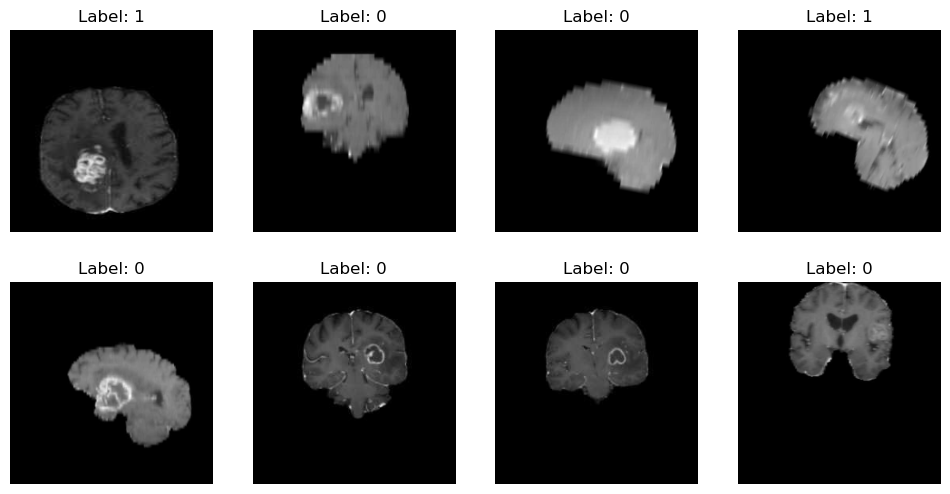

In [39]:
for images, labels in final_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()